# Code Associated with Research Question 5

__Research Question 5__ <br>
"Is theta oscillatory power related to learning performance?"

In [ ]:
# common imports
import numpy as np
import os
import pickle
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.ndimage import zoom, gaussian_filter # smoothing
import copy
import pandas as pd

# statistics
from scipy import stats
import mne # for permutation tests

# own libraries
import neuropsy as npsy

# Set font family for all plots to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

In [ ]:
# [IMPORTANT] Set the hippocampal subfield and stimulus to be analyzed
hp_subfield = 'head'
stimulus    = 'Picture Placed'

#********** PARAMETERS **********#
path_data                   = '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/data/preprocessed'
path_results_Q2             = f'/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 2/Time-frequency Power Analysis'
path_results                = f'/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 5/hippocampus-{hp_subfield}'

postfix_load                = 'analysis'
postfix_save                = 'q5'

stimulus_list               = ['Picture Shown', 'Picture Placed']
cond_column                 = 'Condition (modified)'
conditions                  = ('not learned', 'correct', 'learned-1', 'learned')
hippocampus_subfields       = ('head', 'body & tail')
dict_subfields_regex        = {'head': r'Right_HP_head|Left_HP_head', 'body & tail': r'Right_HP_body|Left_HP_body|Right_HP_tail|Left_HP_tail'}

accuracy_groups             = ['outer', 'inner']
conditions_q5               = ('learned-1', 'learned')


# plot parameters
timepoints                  = np.arange(0, 1280, 1)
frequencies                 = np.arange(2, 13, 1)
xticks                      = [0, 255, 511, 767, 1023, 1279]
xlabels                     = ["- 0.5 s", "stim", "0.5 s", "1 s", "1.5 s", "2 s"]
frequencies_plot            = np.insert(frequencies.astype(float), [0, len(frequencies)], [1.5, 12.5]) # define custom y ticks across frequencies but exclude first and last frequency labels as they the ticks are only for plotting purposes
yticks                      = frequencies_plot
ylabels                     = [int(frequencies_plot[i]) if i > 0 and i < len(frequencies_plot)-1 else "" for i in range(len(frequencies_plot))]

# used for 
n_frequencies               = len(frequencies)
n_timepoints                = len(timepoints)

# set up directory for saving results
if not os.path.exists(path_results) or not os.path.exists(f"{path_results}/data"):
    os.makedirs(path_results)
    os.makedirs(f"{path_results}/data")
    
# save info file in directory
if not os.path.exists(f"{path_results}/info.txt"):
    with open(f"{path_results}/info.txt", "w") as text_file:
        text_file.write(f"Research Question 5: Is theta oscillatory power related to learning performance?\n")
        text_file.write(f"notebook name: Q5 - accuracy and learning performance.ipynb\n")
        text_file.write(f"Data path: {path_data}\n")
        text_file.write(f"Results path: {path_results}\n")

### Load Previous Results

- results from Q1 are loaded
- channels from hippocampus subfield are selected
- trials are assigned to the condition according to the label in the experiment dataframe (see notebook <span style="color: green;">_PRE - categorise trials.ipynb_</span>)
- a new condition is added, called _learned combined_

In [ ]:
filename = f"{path_results_Q2}/data/1.2 tfr_power_results_{stimulus}.pkl"

# load previously computed time-frequency power for all subjects
load_start_time = time.time()
with open(filename, 'rb') as f:
    dict_tfr_power_results_Q1 = pickle.load(f)
print(f"Loading data took {time.time()-load_start_time:.2f} seconds.")

# get conditions and subject ids from the loaded results dictionary
subject_ids = list(dict_tfr_power_results_Q1.keys())


#################### SELECT CHANNELS IN HIPPOCAMPUS SUBFIELD ####################
select_ch_start_time = time.time()
for subject_id in subject_ids:
    # load subject data (only channel dataframe)
    data = npsy.DataHandler(path=path_data, subject_id=subject_id, exp_phase=2, fs=512, verbose=False)
    data.load(load_saved=True, postfix=postfix_load, load_ieeg=False, load_exp=False, load_chan=True, load_targets=False, load_ied=False)
    
    # get channel names that are in the hippocampal subfield
    regex_pattern = dict_subfields_regex[hp_subfield]
    hp_subfield_chans = data.df_chan[data.df_chan['HC_Subfields'].str.contains(regex_pattern, regex=True, case=False)]['name'].tolist()
    
    # check if subject has any channels in the hippocampal subfield
    if len(hp_subfield_chans) == 0:
        print(f"Subject {subject_id} has no channels in the hippocampal subfield {repr(hp_subfield)}.")
        # remove subject from dictionary
        dict_tfr_power_results_Q1.pop(subject_id)
    else:
        # remove channels that are not in the hippocampal subfield
        for ch in list(dict_tfr_power_results_Q1[subject_id].keys()):
            if ch not in hp_subfield_chans:
                dict_tfr_power_results_Q1[subject_id].pop(ch)
# ensure that the subject ids are updated
subject_ids = list(dict_tfr_power_results_Q1.keys())
print(f"Selecting channels done in {time.time()-select_ch_start_time:.2f} seconds.")


#################### ASSIGN TRIALS TO CONDITIONS ####################
dict_tfr_power_results = {c: {s: {} for s in subject_ids} for c in conditions}
assign_start_time = time.time()
for condition in conditions:
    for subject_id in subject_ids:
        dict_tfr_power_results[condition][subject_id] = {ch: {} for ch in dict_tfr_power_results_Q1[subject_id].keys()}
        
        # load subject data (only experiment dataframe)
        data = npsy.DataHandler(path=path_data, subject_id=subject_id, exp_phase=2, fs=512, verbose=False)
        data.load(load_saved=True, postfix=postfix_load, load_exp=True, load_ieeg=False, load_chan=False, load_targets=False, load_ied=False)
        
        # iterate over channels
        for ch in dict_tfr_power_results_Q1[subject_id].keys():
            # iterate over trials
            for trial in dict_tfr_power_results_Q1[subject_id][ch].keys():
                # get trial condition from experiment dataframe
                trial_condition = data.df_exp[data.df_exp['Trial Identifier'] == trial][cond_column].values[0]
                # assign trial respectively in the new dictionary  
                if trial_condition == condition:
                    dict_tfr_power_results[condition][subject_id][ch][trial] = dict_tfr_power_results_Q1[subject_id][ch][trial]
print(f"Assigning trials to conditions done in {time.time()-assign_start_time:.2f} seconds.")
    

#################### GET AVERAGES AS DICT AND (FOR SOME) ARRAY ####################
average_start_time = time.time()
# compute channel average (average each channel across all trials)
dict_tfr_power_results_chan_avg = {c: {s: {} for s in subject_ids} for c in conditions}
for condition in conditions:
    for subject_id in subject_ids:
        for ch in dict_tfr_power_results[condition][subject_id].keys():
            # if only one trial, use the power of that trial as average, otherwise average the power of all trials
            if len(dict_tfr_power_results[condition][subject_id][ch].keys()) == 1:
                print(f"Only one trial for subject {subject_id} in condition {condition} and channel {ch}.")
                dict_tfr_power_results_chan_avg[condition][subject_id][ch] = list(dict_tfr_power_results[condition][subject_id][ch].values())[0]
            else:
                dict_tfr_power_results_chan_avg[condition][subject_id][ch] = np.mean(list(dict_tfr_power_results[condition][subject_id][ch].values()), axis=0)
            
# compute subject average (average each subject across all channels)
dict_tfr_power_results_subj_avg     = {c: {s: {} for s in subject_ids} for c in conditions}
arr_tfr_power_results_subj_avg      = np.zeros((len(conditions), len(subject_ids), n_frequencies, n_timepoints))
for i, condition in enumerate(conditions):
    for j, subject_id in enumerate(subject_ids):
        # if only one channel, use the power of that channel as average, otherwise average the power of all channels
        if len(dict_tfr_power_results_chan_avg[condition][subject_id].keys()) == 1:
            print(f"Only one channel for subject {subject_id} in condition {condition}.")
            dict_tfr_power_results_subj_avg[condition][subject_id] = list(dict_tfr_power_results_chan_avg[condition][subject_id].values())[0]
        else:
            dict_tfr_power_results_subj_avg[condition][subject_id] = np.mean(list(dict_tfr_power_results_chan_avg[condition][subject_id].values()), axis=0)
        arr_tfr_power_results_subj_avg[i, j] = dict_tfr_power_results_subj_avg[condition][subject_id]
    
# compute condition average (average each condition across all subjects)
dict_tfr_power_results_cond_avg     = {c: {} for c in conditions}
arr_tfr_power_results_cond_avg      = np.zeros((len(conditions), n_frequencies, n_timepoints))
for i, condition in enumerate(conditions):
    dict_tfr_power_results_cond_avg[condition] = np.mean(list(dict_tfr_power_results_subj_avg[condition].values()), axis=0)
    arr_tfr_power_results_cond_avg[i] = dict_tfr_power_results_cond_avg[condition]
print(f"Computing averages done in {time.time()-average_start_time:.2f} seconds.")


#################### ADD CONDITION 'LEARNED COMBINED' TO DICTS AND ARRAYS ####################
# add new condition to the main dictionary
dict_tfr_power_results['learned combined'] = {s: {} for s in subject_ids}
for subject_id in subject_ids:
    dict_tfr_power_results['learned combined'][subject_id] = {ch: {} for ch in dict_tfr_power_results[conditions[0]][subject_id].keys()}
    for ch in dict_tfr_power_results[conditions[0]][subject_id].keys():
        # iterate over trials and combine the power of the two learned conditions
        # note:
        #   the keys of the two learned conditions might not be the same, so first iterate over the keys of the first learned condition
        #   and if the key is not in the second learned condition, use the value of the first learned condition,
        #   if the key is in the second learned condition, average the power of the two learned conditions,
        #   then iterate over the keys of the second learned condition and if the key is not in the first learned condition, use the value of the second learned condition
        #   (this is necessary as the keys of the two learned conditions might not be the same)
        #
        # get item numbers of the two learned conditions
        item_number_list_learned_1 = [v.split('-')[0] for v in dict_tfr_power_results['learned-1'][subject_id][ch].keys()]
        item_number_list_learned = [v.split('-')[0] for v in dict_tfr_power_results['learned'][subject_id][ch].keys()]
        # first iterate over trials in the learned-1 condition
        for trial in dict_tfr_power_results['learned-1'][subject_id][ch].keys():
            item_number = trial.split('-')[0]
            if item_number not in item_number_list_learned:
                # use the power of the learned-1 condition
                dict_tfr_power_results['learned combined'][subject_id][ch][item_number] = dict_tfr_power_results['learned-1'][subject_id][ch][trial]
            else:
                # average the power of the two learned conditions
                trial_learned = [k for k in dict_tfr_power_results['learned'][subject_id][ch].keys() if k.split('-')[0] == item_number][0]
                dict_tfr_power_results['learned combined'][subject_id][ch][item_number] = np.mean([dict_tfr_power_results['learned-1'][subject_id][ch][trial], dict_tfr_power_results['learned'][subject_id][ch][trial_learned]], axis=0)
        # add the remaining trials of the learned condition
        for trial in dict_tfr_power_results['learned'][subject_id][ch].keys():
            item_number = trial.split('-')[0]
            if item_number not in item_number_list_learned_1:
                # use the power of the learned condition
                dict_tfr_power_results['learned combined'][subject_id][ch][item_number] = dict_tfr_power_results['learned'][subject_id][ch][trial]
# note: cannot create array of including all channels and trials as they have different shapes

# add new condition to channel average results
dict_tfr_power_results_chan_avg['learned combined'] = {s: {} for s in subject_ids}
for subject_id in subject_ids:
    for ch in dict_tfr_power_results['learned combined'][subject_id].keys():
        # if only one trial, use the power of that trial as average, otherwise average the power of all trials
        if len(dict_tfr_power_results['learned combined'][subject_id][ch].keys()) == 1:
            dict_tfr_power_results_chan_avg['learned combined'][subject_id][ch] = list(dict_tfr_power_results['learned combined'][subject_id][ch].values())[0]
        else:
            dict_tfr_power_results_chan_avg['learned combined'][subject_id][ch] = np.mean(list(dict_tfr_power_results['learned combined'][subject_id][ch].values()), axis=0)
# note: cannot create array of channel averages as they have different shapes

# add new condition to subject average results
dict_tfr_power_results_subj_avg['learned combined'] = {}
for subject_id in subject_ids:
    # if only one channel, use the power of that channel as average, otherwise average the power of all channels
    if len(dict_tfr_power_results_chan_avg['learned combined'][subject_id].keys()) == 1:
        dict_tfr_power_results_subj_avg['learned combined'][subject_id] = list(dict_tfr_power_results_chan_avg['learned combined'][subject_id].values())[0]
    else:
        dict_tfr_power_results_subj_avg['learned combined'][subject_id] = np.mean(list(dict_tfr_power_results_chan_avg['learned combined'][subject_id].values()), axis=0)
# stack new condtion to array
tmp_list = []
for subject_id in subject_ids:
    tmp_list.append(dict_tfr_power_results_subj_avg['learned combined'][subject_id])
arr_tfr_power_results_subj_avg = np.vstack((arr_tfr_power_results_subj_avg, np.asanyarray(tmp_list)[np.newaxis, :]))
    
# add new condition to condition average results
for subject_id in subject_ids:
    dict_tfr_power_results_cond_avg['learned combined'] = np.mean(list(dict_tfr_power_results_subj_avg['learned combined'].values()), axis=0)
# stack new condtion to array
arr_tfr_power_results_cond_avg = np.vstack((arr_tfr_power_results_cond_avg, dict_tfr_power_results_cond_avg['learned combined'][np.newaxis, :]))

conditions = conditions + ('learned combined',)
print("New condition 'learned combined' added to results.")

# clean up to save memory
del dict_tfr_power_results_Q1

Loading data took 15.98 seconds.
Subject 11 has no channels in the hippocampal subfield.
Selecting channels done in 0.41 seconds.
Assigning trials to conditions done in 4.80 seconds.
Only one trial for subject 05 in condition correct and channel B' 01.
Only one trial for subject 05 in condition correct and channel B' 02.
Computing averages done in 0.10 seconds.
New condition 'learned combined' added to results.


In [ ]:
filename = f"{path_results_Q2}/data/1.2 tfr_power_results_{stimulus}.pkl"

# load previously computed time-frequency power for all subjects
load_start_time = time.time()
with open(filename, 'rb') as f:
    dict_tfr_power_results_Q1 = pickle.load(f)
print(f"Loading data took {time.time()-load_start_time:.2f} seconds.")

# get conditions and subject ids from the loaded results dictionary
subject_ids = list(dict_tfr_power_results_Q1.keys())


#################### SELECT CHANNELS IN HIPPOCAMPUS SUBFIELD ####################
select_ch_start_time = time.time()
for subject_id in subject_ids:
    # load subject data (only channel dataframe)
    data = npsy.DataHandler(path=path_data, subject_id=subject_id, exp_phase=2, fs=512, verbose=False)
    data.load(load_saved=True, postfix=postfix_load, load_ieeg=False, load_exp=False, load_chan=True, load_targets=False, load_ied=False)
    
    # get channel names that are in the hippocampal subfield
    regex_pattern = dict_subfields_regex[hp_subfield]
    hp_subfield_chans = data.df_chan[data.df_chan['HC_Subfields'].str.contains(regex_pattern, regex=True, case=False)]['name'].tolist()
    
    # check if subject has any channels in the hippocampal subfield
    if len(hp_subfield_chans) == 0:
        print(f"Subject {subject_id} has no channels in the hippocampal subfield {repr(hp_subfield)}.")
        # remove subject from dictionary
        dict_tfr_power_results_Q1.pop(subject_id)
    else:
        # remove channels that are not in the hippocampal subfield
        for ch in list(dict_tfr_power_results_Q1[subject_id].keys()):
            if ch not in hp_subfield_chans:
                dict_tfr_power_results_Q1[subject_id].pop(ch)
# ensure that the subject ids are updated
subject_ids = list(dict_tfr_power_results_Q1.keys())
print(f"Selecting channels done in {time.time()-select_ch_start_time:.2f} seconds.")


#################### ASSIGN TRIALS TO CONDITIONS ####################
dict_tfr_power_results = {c: {s: {} for s in subject_ids} for c in conditions}
assign_start_time = time.time()
for condition in conditions:
    for subject_id in subject_ids:
        dict_tfr_power_results[condition][subject_id] = {ch: {} for ch in dict_tfr_power_results_Q1[subject_id].keys()}
        
        # load subject data (only experiment dataframe)
        data = npsy.DataHandler(path=path_data, subject_id=subject_id, exp_phase=2, fs=512, verbose=False)
        data.load(load_saved=True, postfix=postfix_load, load_exp=True, load_ieeg=False, load_chan=False, load_targets=False, load_ied=False)
        
        # iterate over channels
        for ch in dict_tfr_power_results_Q1[subject_id].keys():
            # iterate over trials
            for trial in dict_tfr_power_results_Q1[subject_id][ch].keys():
                # get trial condition from experiment dataframe
                trial_condition = data.df_exp[data.df_exp['Trial Identifier'] == trial][cond_column].values[0]
                # assign trial respectively in the new dictionary  
                if trial_condition == condition:
                    dict_tfr_power_results[condition][subject_id][ch][trial] = dict_tfr_power_results_Q1[subject_id][ch][trial]
print(f"Assigning trials to conditions done in {time.time()-assign_start_time:.2f} seconds.")
    

#################### GET AVERAGES AS DICT AND (FOR SOME) ARRAY ####################
average_start_time = time.time()
# compute channel average (average each channel across all trials)
dict_tfr_power_results_chan_avg = {c: {s: {} for s in subject_ids} for c in conditions}
for condition in conditions:
    for subject_id in subject_ids:
        for ch in dict_tfr_power_results[condition][subject_id].keys():
            # if only one trial, use the power of that trial as average, otherwise average the power of all trials
            if len(dict_tfr_power_results[condition][subject_id][ch].keys()) == 1:
                print(f"Only one trial for subject {subject_id} in condition {condition} and channel {ch}.")
                dict_tfr_power_results_chan_avg[condition][subject_id][ch] = list(dict_tfr_power_results[condition][subject_id][ch].values())[0]
            else:
                dict_tfr_power_results_chan_avg[condition][subject_id][ch] = np.mean(list(dict_tfr_power_results[condition][subject_id][ch].values()), axis=0)
            
# compute subject average (average each subject across all channels)
dict_tfr_power_results_subj_avg     = {c: {s: {} for s in subject_ids} for c in conditions}
arr_tfr_power_results_subj_avg      = np.zeros((len(conditions), len(subject_ids), n_frequencies, n_timepoints))
for i, condition in enumerate(conditions):
    for j, subject_id in enumerate(subject_ids):
        # if only one channel, use the power of that channel as average, otherwise average the power of all channels
        if len(dict_tfr_power_results_chan_avg[condition][subject_id].keys()) == 1:
            print(f"Only one channel for subject {subject_id} in condition {condition}.")
            dict_tfr_power_results_subj_avg[condition][subject_id] = list(dict_tfr_power_results_chan_avg[condition][subject_id].values())[0]
        else:
            dict_tfr_power_results_subj_avg[condition][subject_id] = np.mean(list(dict_tfr_power_results_chan_avg[condition][subject_id].values()), axis=0)
        arr_tfr_power_results_subj_avg[i, j] = dict_tfr_power_results_subj_avg[condition][subject_id]
    
# compute condition average (average each condition across all subjects)
dict_tfr_power_results_cond_avg     = {c: {} for c in conditions}
arr_tfr_power_results_cond_avg      = np.zeros((len(conditions), n_frequencies, n_timepoints))
for i, condition in enumerate(conditions):
    dict_tfr_power_results_cond_avg[condition] = np.mean(list(dict_tfr_power_results_subj_avg[condition].values()), axis=0)
    arr_tfr_power_results_cond_avg[i] = dict_tfr_power_results_cond_avg[condition]
print(f"Computing averages done in {time.time()-average_start_time:.2f} seconds.")


#################### ADD CONDITION 'LEARNED COMBINED' TO DICTS AND ARRAYS ####################
# add new condition to the main dictionary
dict_tfr_power_results['learned combined'] = {s: {} for s in subject_ids}
for subject_id in subject_ids:
    dict_tfr_power_results['learned combined'][subject_id] = {ch: {} for ch in dict_tfr_power_results[conditions[0]][subject_id].keys()}
    for ch in dict_tfr_power_results[conditions[0]][subject_id].keys():
        # iterate over trials and combine the power of the two learned conditions
        # note:
        #   the keys of the two learned conditions might not be the same (if trial is excluded during analysis for either being too short, too close to the next trial, or having IEDs in the signal), 
        #   so first iterate over the keys of the first learned condition and if the key is not in the second learned condition, use the value of the first learned condition,
        #   if the key is in the second learned condition, average the power of the two learned conditions, then iterate over the keys of the second learned condition 
        #   and if the key is not in the first learned condition, use the value of the second learned condition
        #   (this is necessary as the keys of the two learned conditions might not be the same)
        #
        # get item numbers of the two learned conditions
        item_number_list_learned_1 = [v.split('-')[0] for v in dict_tfr_power_results['learned-1'][subject_id][ch].keys()]
        item_number_list_learned = [v.split('-')[0] for v in dict_tfr_power_results['learned'][subject_id][ch].keys()]
        # first iterate over trials in the learned-1 condition
        for trial in dict_tfr_power_results['learned-1'][subject_id][ch].keys():
            item_number = trial.split('-')[0]
            if item_number not in item_number_list_learned:
                # use the power of the learned-1 condition
                dict_tfr_power_results['learned combined'][subject_id][ch][item_number] = dict_tfr_power_results['learned-1'][subject_id][ch][trial]
            else:
                # average the power of the two learned conditions
                trial_learned = [k for k in dict_tfr_power_results['learned'][subject_id][ch].keys() if k.split('-')[0] == item_number][0]
                dict_tfr_power_results['learned combined'][subject_id][ch][item_number] = np.mean([dict_tfr_power_results['learned-1'][subject_id][ch][trial], dict_tfr_power_results['learned'][subject_id][ch][trial_learned]], axis=0)
        # add the remaining trials of the learned condition
        for trial in dict_tfr_power_results['learned'][subject_id][ch].keys():
            item_number = trial.split('-')[0]
            if item_number not in item_number_list_learned_1:
                # use the power of the learned condition
                dict_tfr_power_results['learned combined'][subject_id][ch][item_number] = dict_tfr_power_results['learned'][subject_id][ch][trial]
# note: cannot create array of including all channels and trials as they have different shapes

# add new condition to channel average results
dict_tfr_power_results_chan_avg['learned combined'] = {s: {} for s in subject_ids}
for subject_id in subject_ids:
    for ch in dict_tfr_power_results['learned combined'][subject_id].keys():
        # if only one trial, use the power of that trial as average, otherwise average the power of all trials
        if len(dict_tfr_power_results['learned combined'][subject_id][ch].keys()) == 1:
            dict_tfr_power_results_chan_avg['learned combined'][subject_id][ch] = list(dict_tfr_power_results['learned combined'][subject_id][ch].values())[0]
        else:
            dict_tfr_power_results_chan_avg['learned combined'][subject_id][ch] = np.mean(list(dict_tfr_power_results['learned combined'][subject_id][ch].values()), axis=0)
# note: cannot create array of channel averages as they have different shapes

# add new condition to subject average results
dict_tfr_power_results_subj_avg['learned combined'] = {}
for subject_id in subject_ids:
    # if only one channel, use the power of that channel as average, otherwise average the power of all channels
    if len(dict_tfr_power_results_chan_avg['learned combined'][subject_id].keys()) == 1:
        dict_tfr_power_results_subj_avg['learned combined'][subject_id] = list(dict_tfr_power_results_chan_avg['learned combined'][subject_id].values())[0]
    else:
        dict_tfr_power_results_subj_avg['learned combined'][subject_id] = np.mean(list(dict_tfr_power_results_chan_avg['learned combined'][subject_id].values()), axis=0)
# stack new condtion to array
tmp_list = []
for subject_id in subject_ids:
    tmp_list.append(dict_tfr_power_results_subj_avg['learned combined'][subject_id])
arr_tfr_power_results_subj_avg = np.vstack((arr_tfr_power_results_subj_avg, np.asanyarray(tmp_list)[np.newaxis, :]))
    
# add new condition to condition average results
for subject_id in subject_ids:
    dict_tfr_power_results_cond_avg['learned combined'] = np.mean(list(dict_tfr_power_results_subj_avg['learned combined'].values()), axis=0)
# stack new condtion to array
arr_tfr_power_results_cond_avg = np.vstack((arr_tfr_power_results_cond_avg, dict_tfr_power_results_cond_avg['learned combined'][np.newaxis, :]))

conditions = conditions + ('learned combined',)
print("New condition 'learned combined' added to results.")

# clean up to save memory
del dict_tfr_power_results_Q1

Loading data took 15.75 seconds.
Subject 11 has no channels in the hippocampal subfield 'head'.
Selecting channels done in 0.22 seconds.
Assigning trials to conditions done in 5.52 seconds.
Only one trial for subject 05 in condition correct and channel B' 01.
Only one trial for subject 05 in condition correct and channel B' 02.
Computing averages done in 0.24 seconds.
New condition 'learned combined' added to results.


### Illustrate Radius Threshold used in Correlation Analysis

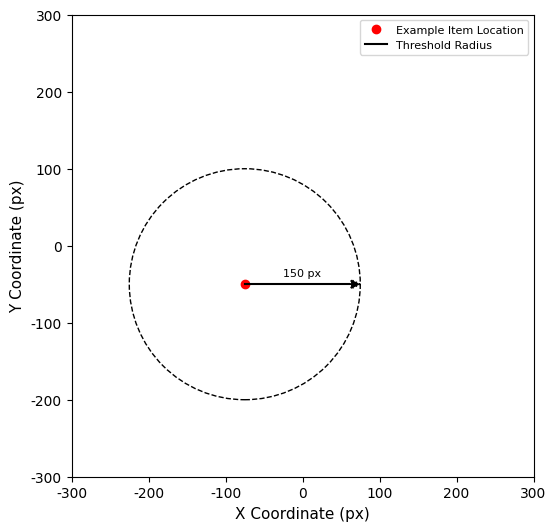

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Screen size and center point
screen_size             = 600
half_screen             = screen_size // 2  # 300 (center in absolute coordinates)
example_x, example_y    = (screen_size // 2)+-75, (screen_size // 2)-50  # (300, 300)

# Create the figure
fig, ax = plt.subplots(figsize=(6, 6))

# Draw the circular boundaries
circle = plt.Circle((example_x, example_y), 150, fill=False, edgecolor='black', linestyle='dashed')

# Add circles to the plot
ax.add_patch(circle)


# add dot at centre location
ax.plot(example_x, example_y, 'ro', label="Example Item Location")
# add threshold radius line
ax.plot([example_x, example_x+135], [example_y, example_y], color='black', linestyle='-', label='Threshold Radius')
# plot arrowhead on threhold radius line
ax.arrow(example_x+135, example_y, 3, 0, head_width=12, head_length=12, fill=True, fc='black', ec='black', linestyle='dotted')
# add text to arrowhead
ax.text(example_x+50, example_y+10, "150 px", fontsize=8, color='black')

# Adjust tick labels to show relative coordinates
tick_positions  = np.linspace(0, screen_size, num=7)  # 7 ticks from 0 to 600
tick_labels     = np.linspace(-half_screen, half_screen, num=7, dtype=int)  # Convert to relative values
# tick_positions  = [25,      100,    175,    250,    325]
# tick_labels     = [-150,    -75,    0,      75,     150]
ax.set_xticks(tick_positions)
ax.set_yticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

# Formatting the plot
ax.set_xlim(0, screen_size)
ax.set_ylim(0, screen_size)
ax.set_xlabel("X Coordinate (px)", fontsize=11)
ax.set_ylabel("Y Coordinate (px)", fontsize=11)
ax.legend(fontsize=8)
ax.set_aspect('equal')  # Keep the aspect ratio square

# save figure
plt.savefig(f"{path_results}/MT-fig-learning-performance.png", dpi=300)

plt.show()

# 1. Correlation Analysis

Correlation between the trial error and evoked power response for each of the learned conditions (learned-1 and learned).

- variable 1: Trial Error (Euclidean distance between true location and placed location)
- variable 2: Power (averaged evoked theta power in the time-frequency window-of-interest)

### Helper Functions

In [5]:
def cut_tfr_data(tfr_data, stimulus_onset, fs, freq_start, freq_end, time_start, time_end):
    """cut_tfr_data Cut time-frequency power data for a specific time-frequency range and average area.

    Args:
        tfr_data (2darray): Time-frequency power data to cut.
        stimulus_onset (int): The stimulus onset time in time points.
        fs (int): The sampling frequency in Hz.
        freq_start (float): The start frequency of the range to cut the time-frequency power data in Hz.
        freq_end (float): The end frequency of the range to cut the time-frequency power data in Hz.
        time_start (float): The start time of the range to cut the time-frequency power data in seconds.
        time_end (float): The end time of the range to cut the time-frequency power data in seconds.

    Returns:
        tfr_data_cut (float): The average time-frequency power data for the specified range.
        freq_start_idx (int): The start frequency index of the range.
        freq_end_idx (int): The end frequency index of the range.
        time_start_idx (int): The start time index of the range.
        time_end_idx (int): The end time index of the range.
    """    
    # convert frequency range to indices
    freq_start_idx = np.where(frequencies == freq_start)[0][0].astype(int)
    freq_end_idx = np.where(frequencies == freq_end)[0][0].astype(int) + 1

    # convert time range to indices with respect to the stimulus onset
    time_start_idx = np.floor(stimulus_onset + (time_start * fs)).astype(int)
    time_start_idx = 0 if time_start_idx < 0 else time_start_idx
    time_end_idx = np.floor(stimulus_onset + (time_end * fs)).astype(int)
    
    # cut time-frequency power data and average flattened array
    tfr_data_cut = np.mean(tfr_data[freq_start_idx:freq_end_idx, time_start_idx:time_end_idx], axis=None)
    return tfr_data_cut, freq_start_idx, freq_end_idx, time_start_idx, time_end_idx

### 1.1 Create Dataframe for Correlation Analysis

In [6]:
condition               = 'learned'
freq_start, freq_end    = 3, 6      # frequency range to cut (in Hz)
time_start, time_end    = 0.3, 0.525   # time range to cut (in seconds)

# common parameters
stimulus_onset          = 255
fs                      = 512


#################### CREATE DATAFRAME FOR CORRELATION ANALYSIS ####################
df = pd.DataFrame(columns=["Subject ID", "Channel", "Trial Identifier", "Trial Error", "Power"])
for subject_id in subject_ids:
    # load subject data (only experiment dataframe)
    data = npsy.DataHandler(path=path_data, subject_id=subject_id, exp_phase=2, fs=512, verbose=False)
    data.load(load_saved=True, postfix=postfix_load, load_exp=True, load_ieeg=False, load_chan=False, load_targets=False, load_ied=False)
    
    # get trial errors for the subject in condition 'learned'
    for ch in dict_tfr_power_results[condition][subject_id].keys():
        for trial in dict_tfr_power_results[condition][subject_id][ch].keys():
            # get trial error
            trial_error = data.df_exp[data.df_exp['Trial Identifier'] == trial]['Trial Error'].values[0]
            # get power values for the trial
            trial_power = dict_tfr_power_results[condition][subject_id][ch][trial]
            # cut the power values for the specified time-frequency range
            power, _, _, _, _ = cut_tfr_data(trial_power, stimulus_onset, fs, freq_start, freq_end, time_start, time_end)
            # create a temporary pandas dataframe to concatenate with the full dataframe
            df_tmp = pd.DataFrame([[subject_id, ch, trial, trial_error, power]], columns=df.columns)
            # append values to the dataframe
            df = pd.concat([df if not df.empty else None, df_tmp], ignore_index=True)


#################### IDENTIFY OUTLIERS ####################
# create new column for outliers
df['Outlier'] = False
for subject_id in subject_ids:
    # compute z-scores for the power values within the subject
    df_subject = df[df['Subject ID'] == subject_id]
    z_scores = stats.zscore(df_subject['Power'])
    # identify outliers based on z-scores
    outliers = np.abs(z_scores) > 3
    # update the dataframe with the outliers (True/False)
    df.loc[df['Subject ID'] == subject_id, 'Outlier'] = outliers
    

# save dataframe
df.to_csv(f"{path_results}/data/1.1 df_correlation.csv", index=False)

NameError: name 'subject_ids' is not defined

### 1.2 Scatter Plot with Outliers

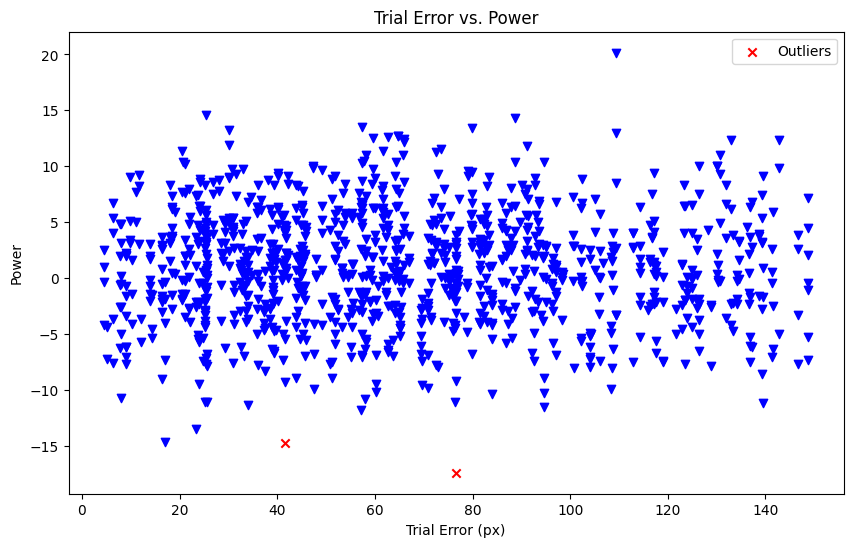

In [ ]:
# scatter plot of trial error and power values with outliers and each subject in a different color
plt.figure(figsize=(10, 6))
# plot non-outliers
plt.scatter(df[~df['Outlier']]['Trial Error'], df[~df['Outlier']]['Power'], c='blue', marker='v')
# plot outliers
plt.scatter(df[df['Outlier']]['Trial Error'], df[df['Outlier']]['Power'], c='red', marker='x', label="Outliers")
# plt.xlabel("Trial Error (px)", fontsize=11)
plt.xlabel(r'Error ($\|\mathbf{x} - \mathbf{y}\|_2$)', fontsize=11)
plt.ylabel("Average Power (dB)", fontsize=11)
# plt.title("Trial Error vs. Power")
plt.legend()

# save figure
plt.savefig(f"{path_results}/MT-fig-corr-outliers.png", dpi=300)
plt.show()

### 1.3 Pearson's Correlation

In [10]:
# compute the pearson correlation coefficient and p-value for the power values and trial errors without outliers
corr, p_val = stats.pearsonr(df[~df['Outlier']]['Trial Error'], df[~df['Outlier']]['Power'])
print(f"Pearson correlation coefficient: {corr:.2f}")
print(f"Pearson correlation p-value: {p_val:.2f}")

# compute the spearman correlation coefficient and p-value for the power values and trial errors with outliers
corr, p_val = stats.pearsonr(df['Trial Error'], df['Power'])
print(f"Pearson correlation coefficient: {corr:.2f}")
print(f"Pearson correlation p-value: {p_val:.2f}")

Pearson correlation coefficient: -0.01
Pearson correlation p-value: 0.73
Pearson correlation coefficient: -0.01
Pearson correlation p-value: 0.76


In [54]:
df[df['Outlier']]

,Subject ID,Channel,Trial Identifier,Trial Error,Power,Outlier
44,03,B' 02,34-10,6.32,52.322421,True
90,03,B' 03,34-10,6.32,63.445082,True
134,03,B' 04,34-10,6.32,60.346017,True
181,03,B' 05,34-10,6.32,54.678068,True
992,10,B' 03,25-6,60.17,-15.152436,True
1319,15,B' 04,33-2,63.66,14.567664,True
1542,19,B' 03,46-2,109.73,-18.980414,True


In [11]:
df[df['Outlier']]

,Subject ID,Channel,Trial Identifier,Trial Error,Power,Outlier
173,04,B 03,21-3,41.68,-14.794762,True
481,07,B 03,29-6,76.56,-17.409611,True
